# Analysis of YouTube Content Creation Evolution

This notebook explores the frequency and consistency of content creation across different YouTube channel categories over time, using the YouNiverse dataset.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the datasets
channel_data = pd.read_csv("data/df_channels_en_with_monetization.csv", dtype={
        'has_affiliate': 'boolean',
        'has_sponsorships': 'boolean',
        'has_merchandise': 'boolean'
    })

timeseries_data = pd.read_csv("data/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
video_data = pd.read_feather("data/yt_metadata_helper.feather")

In [17]:
channel_data.head(5)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,has_affiliate,has_sponsorships,has_merchandise
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087,9800.0,156700.0,117600.0,1900000.00,<NA>,<NA>,<NA>
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087,NaN,NaN,NaN,NaN,False,False,True
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087,0.0,0.0,0.0,0.05,False,False,False
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087,178700.0,2900000.0,2100000.0,34300000.00,False,False,False


In [18]:
timeseries_data.head(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [19]:
video_data.head(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0


In [20]:
channel_data['join_date'] = pd.to_datetime(channel_data['join_date'])
video_data['upload_date'] = pd.to_datetime(video_data['upload_date'])
timeseries_data['datetime'] = pd.to_datetime(timeseries_data['datetime'])

In [21]:
channel_data.isna().sum()

category_cc                    128
join_date                        1
channel                          0
name_cc                         10
subscribers_cc                   0
videos_cc                        0
subscriber_rank_sb               0
weights                          0
lowest_monthly_earnings     136175
highest_monthly_earnings    136175
lowest_yearly_earnings      136175
highest_yearly_earnings     136175
has_affiliate               101062
has_sponsorships            101062
has_merchandise             101062
dtype: int64

We might want to remove samples that have NaN category and/or NaN name.

In [22]:
channel_data.shape

(136470, 15)

In [23]:
# Remove samples that have no category and/or name
channel_data = channel_data.dropna(subset=['category_cc', 'name_cc'])

In [24]:
# New shape after removing samples
channel_data.shape

(136332, 15)

In [27]:
timeseries_data.isna().sum()

channel             0
category        20584
datetime            0
views               0
delta_views         0
subs                0
delta_subs          0
videos              0
delta_videos        0
activity            0
dtype: int64

In [28]:
timeseries_data.shape

(18872499, 10)

In [30]:
timeseries_data = timeseries_data.dropna()

In [ ]:
# New shape after removing samples
timeseries_data.shape

(18851915, 10)

In [25]:
video_data.isna().sum()

categories             0
channel_id             0
dislike_count    1631458
display_id             0
duration               0
like_count       1631458
upload_date            0
view_count           654
dtype: int64

The fact that there are some NaN values about the dislike, like and view counts won't affect our research about the frequency and consistency of content creation, so we can keep all the data of the video metadata.

In [26]:
video_data.shape

(72924794, 8)

In [32]:
# Add year and month columns of upload date of the video data to facilitate time-based analysis
video_data['year'] = video_data['upload_date'].dt.year
video_data['month'] = video_data['upload_date'].dt.to_period('M')

In [35]:
# Merge with channel metadata if needed
channel_video_data = video_data.merge(
    channel_data,
    left_on='channel_id', # Column name in video data
    right_on='channel',   # Column name in channel data
    how='inner'
)

In [40]:
channel_video_data = channel_video_data.drop(columns='channel')

In [41]:
channel_video_data = channel_video_data.rename(
    columns={
        'categories': 'video_category',
        'category_cc': 'channel_category'
    }
)

In [42]:
channel_video_data.columns

Index(['video_category', 'channel_id', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count', 'year', 'month',
       'channel_category', 'join_date', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'has_affiliate', 'has_sponsorships',
       'has_merchandise'],
      dtype='object')

In [43]:
channel_video_data.head(5)

,video_category,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,year,month,...,videos_cc,subscriber_rank_sb,weights,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,has_affiliate,has_sponsorships,has_merchandise
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0,2016,2016-09,...,2398,54617.0,3.5155,NaN,NaN,NaN,NaN,False,False,False


In [44]:
channel_video_data.shape

(72882785, 24)

In [48]:
# Identify rows where channel_category is different from video_category
mismatched_categories = channel_video_data[channel_video_data['channel_category'] != channel_video_data['video_category']]

# Count the mismatched samples
num_mismatched = mismatched_categories.shape[0]

print(f"Number of samples with mismatched categories: {num_mismatched}")

# Percentage of mismatched samples
percentage_mismatched = (num_mismatched / channel_video_data.shape[0]) * 100

print(f"Percentage of samples with mismatched categories: {percentage_mismatched:.2f}%")

Number of samples with mismatched categories: 13341605
Percentage of samples with mismatched categories: 18.31%


Since some channels assigned as a certain category create videos of another category (18.31%) as the one they are assigned, it might be good to make a frequency and consistency analysis with respect to the channels and another analysis with respect to the video categories.

## Step 1: Channels Analysis

### Frequency Analysis

We define frequency as the number of uploads made by channels within a given category over a specific time period (e.g., per year, per month). It provides a measure of how often content is being uploaded for each category.

We care about frequency because it shows how active channels in each category are over time and it helps identify which categories are growing or declining in activity. In our case, higher frequencies may indicate more professionalized or competitive categories.


In [71]:
# Calculate the number of uploads per category per year
frequency_analysis = channel_video_data.groupby(['channel_category', 'year', 'month']).size().reset_index(name='upload_count')

print(frequency_analysis.head())

   channel_category  year    month  upload_count
0  Autos & Vehicles  2005  2005-12             1
1  Autos & Vehicles  2006  2006-01             4
2  Autos & Vehicles  2006  2006-02           117
3  Autos & Vehicles  2006  2006-03            29
4  Autos & Vehicles  2006  2006-04            21


#### Yearly Growth per Category

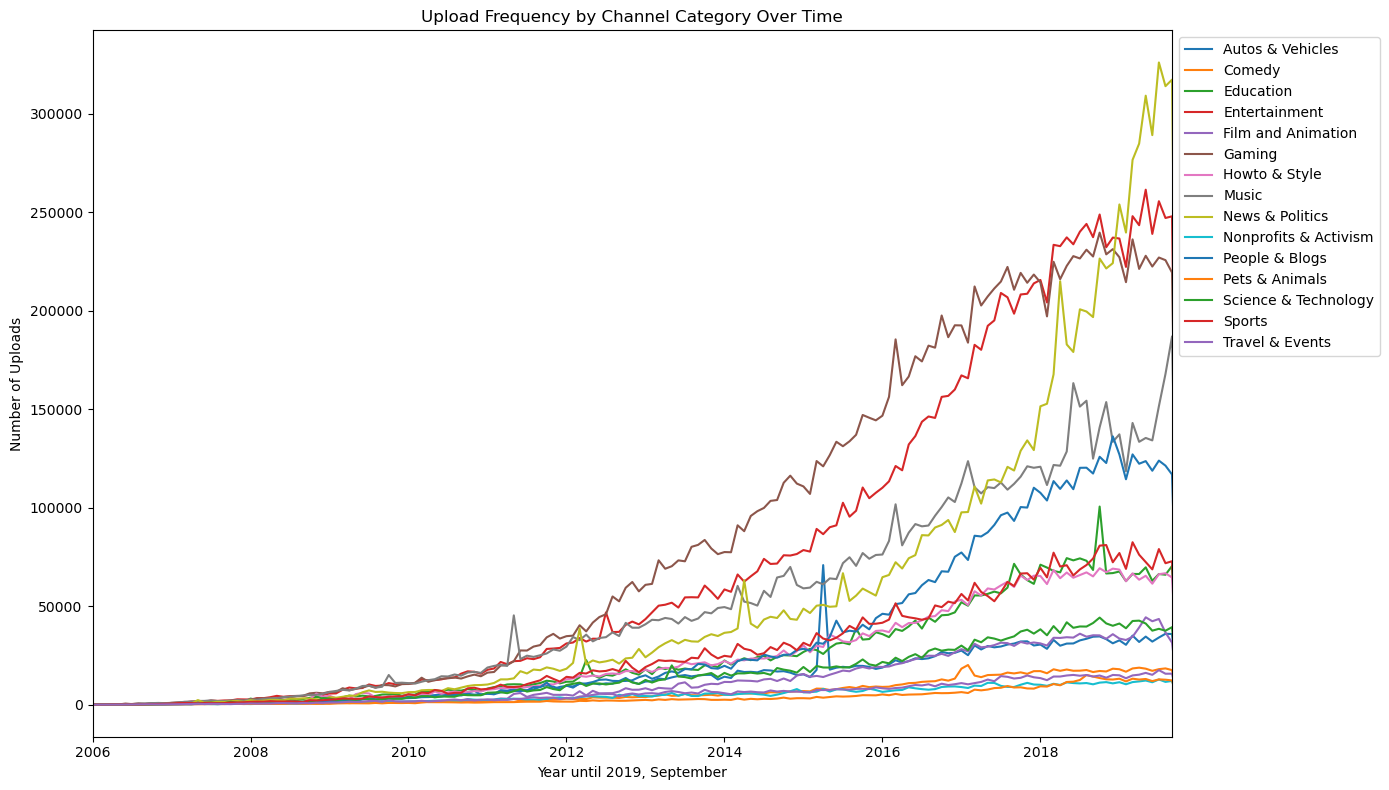

In [ ]:
temp_df = frequency_analysis.copy()

temp_df['month'] = frequency_analysis['month'].dt.month
temp_df['time'] = frequency_analysis['year'] + (temp_df['month'] - 1) / 12

# We stop at year 2019, month September because there are almost no data to plot after this date
cutoff_year = 2019 + (9 - 1) / 12

# Plot upload frequencies over time
plt.figure(figsize=(14, 8))
categories = temp_df['channel_category'].unique()

for category in categories:
    subset = temp_df[temp_df['channel_category'] == category]
    plt.plot(subset['time'], subset['upload_count'], label=category)

# Customize the plot
plt.title("Upload Frequency by Channel Category Over Time")
plt.xlabel("Year until 2019, September")
plt.ylabel("Number of Uploads")
plt.xlim(2006, cutoff_year)  # Limit the x-axis to the range [2006, 2019.91]
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


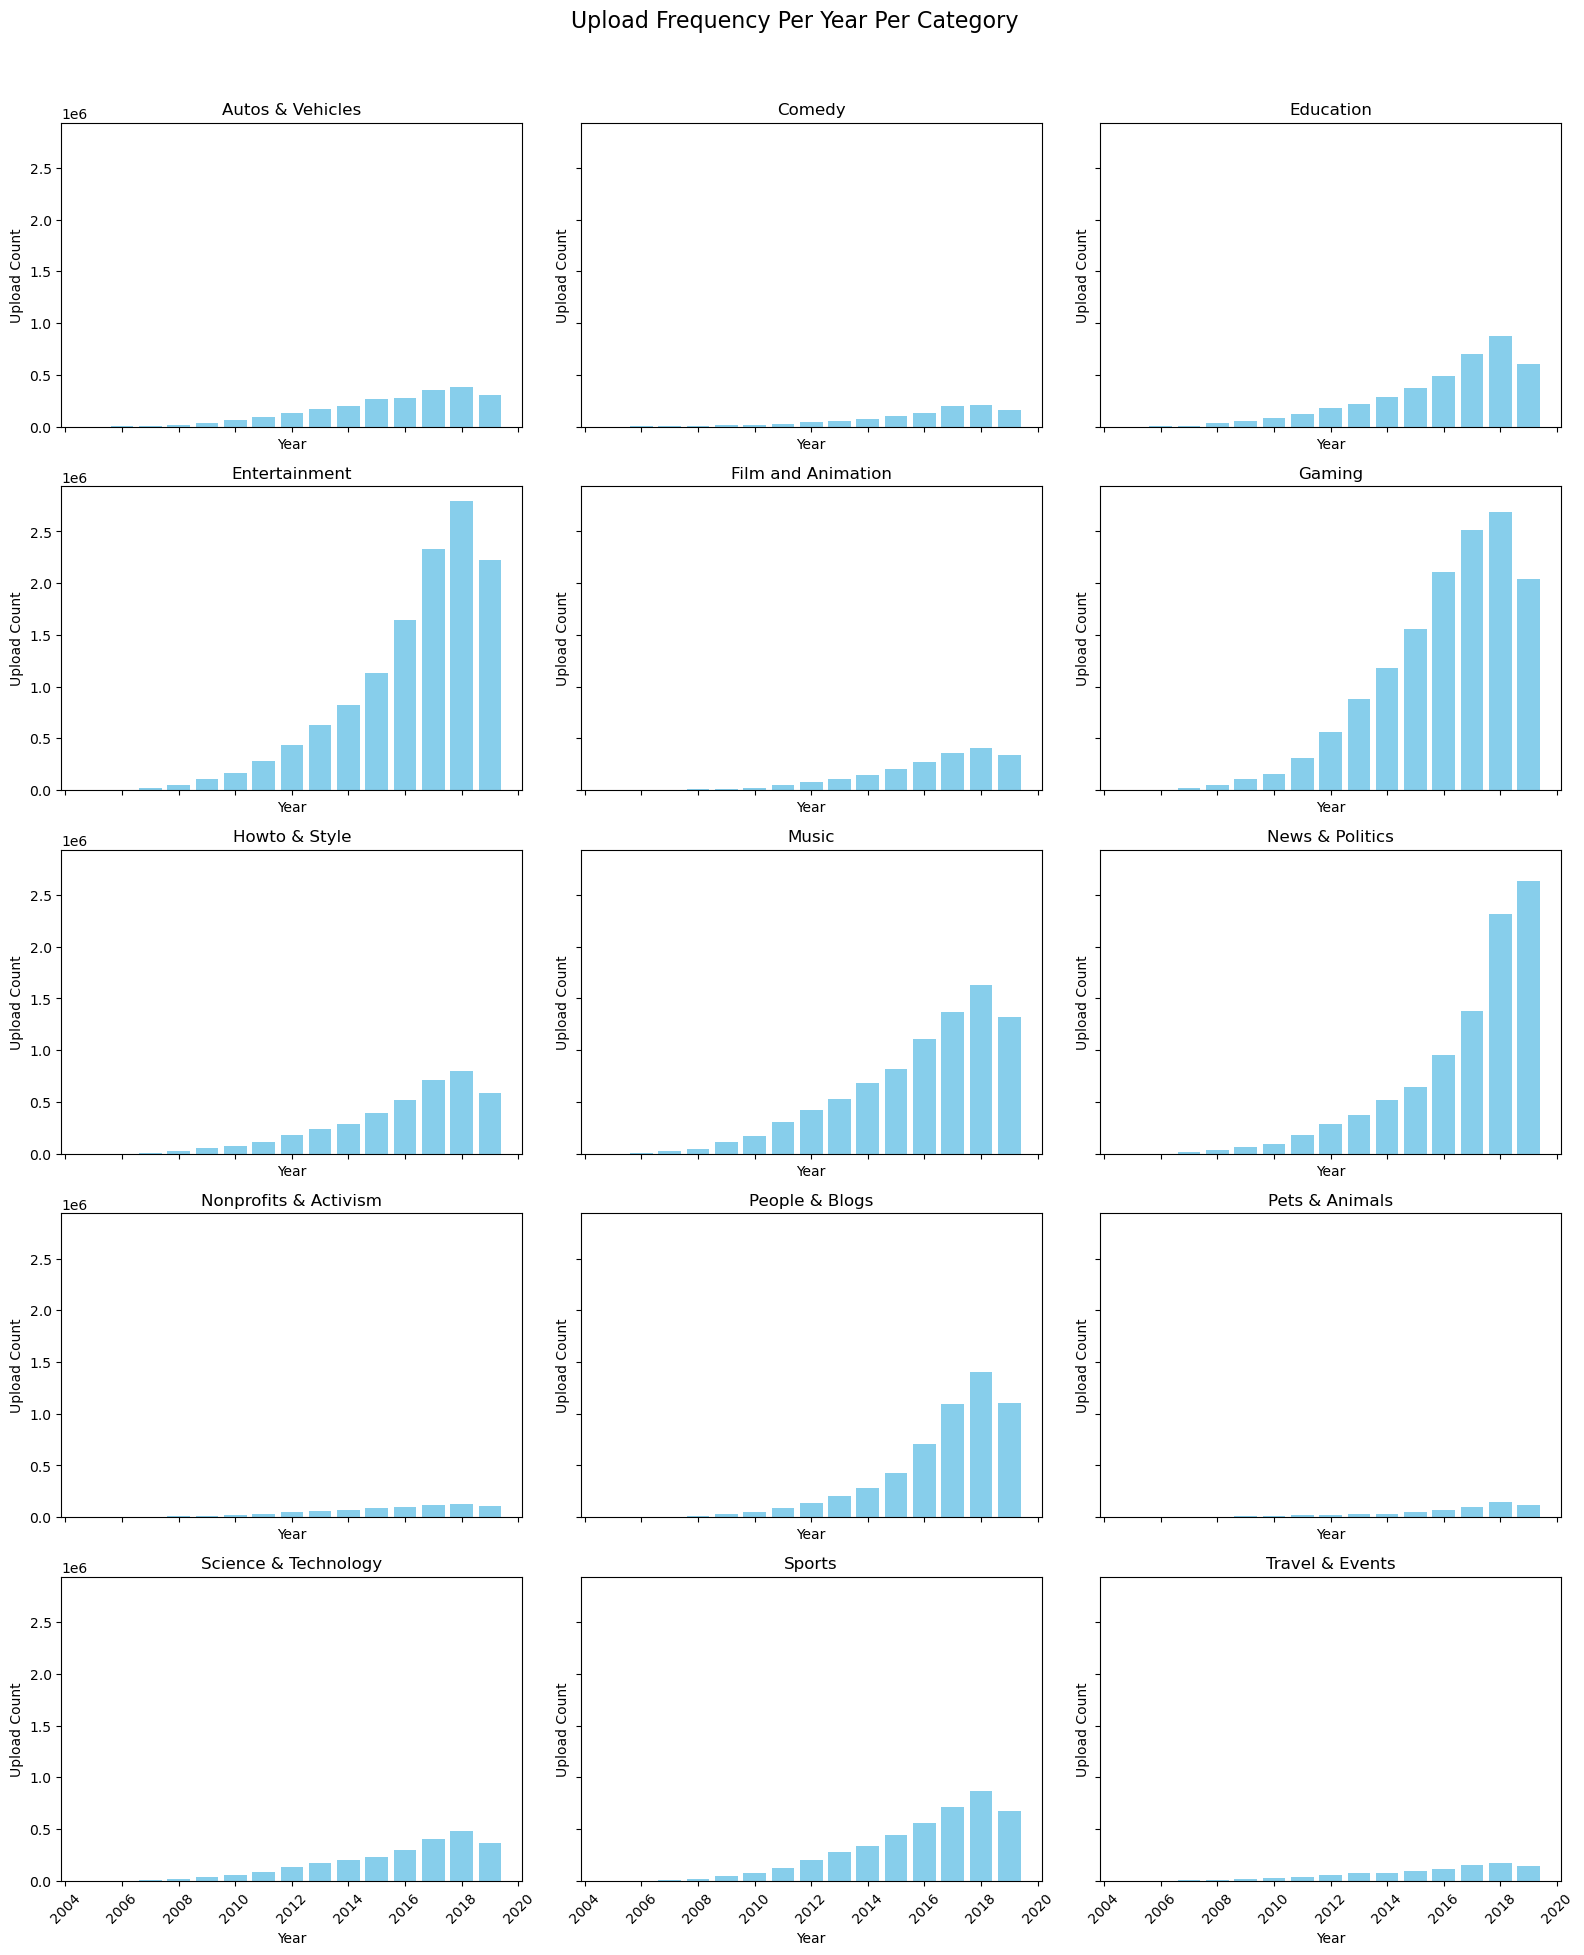

In [ ]:
# Group by channel category and year to calculate upload frequency
yearly_frequency = frequency_analysis.groupby(['channel_category', 'year']).agg({'upload_count': 'sum'}).reset_index()

# Get the unique categories
categories = yearly_frequency['channel_category'].unique()

# Number of subplots
n_categories = len(categories)
n_cols = 3
n_rows = 5

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each category in a separate subplot
for i, category in enumerate(categories):
    # Filter data for the category
    category_data = yearly_frequency[yearly_frequency['channel_category'] == category]
    axes[i].bar(category_data['year'], category_data['upload_count'], color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(category)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Upload Count")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle("Upload Frequency Per Year Per Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The categories that witnessed the biggest upload growth are: Music, News & Politics, Gaming, Entertainment and People & Blog. Their growth might indicate a professionalization that could be correlated with the consistency analysis.

#### Upload Frequency per Channel

In [83]:
# Count uploads per channel
channel_uploads = channel_video_data.groupby(['channel_id', 'channel_category']).size().reset_index(name='upload_count')

# Compute average uploads per channel for each category
average_uploads_per_category = channel_uploads.groupby('channel_category')['upload_count'].mean().reset_index(name='avg_uploads_per_channel')

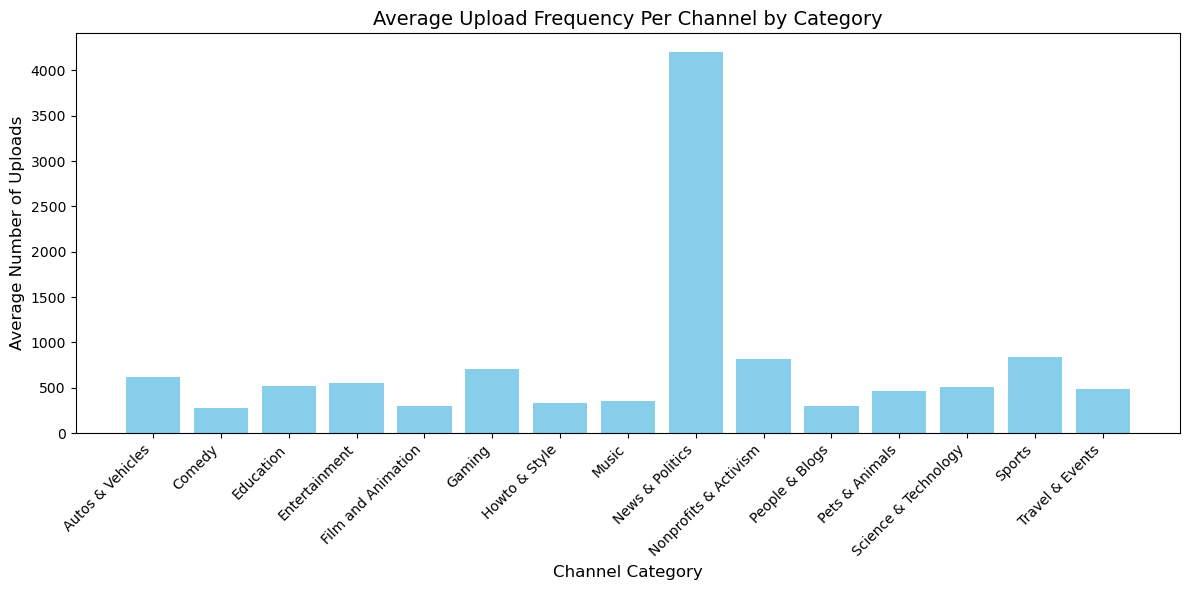

In [84]:
plt.figure(figsize=(12, 6))
plt.bar(average_uploads_per_category['channel_category'], average_uploads_per_category['avg_uploads_per_channel'], color='skyblue')

# Customize the plot
plt.title("Average Upload Frequency Per Channel by Category", fontsize=14)
plt.xlabel("Channel Category", fontsize=12)
plt.ylabel("Average Number of Uploads", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate category names for better readability
plt.tight_layout()

# Show the plot
plt.show()

#### Relationship with Engagement

In [92]:
# Aggregate upload frequency, engagement metrics, and additional channel data
channel_engagement = channel_video_data.groupby('channel_id').agg({
    'upload_date': 'count',         # Total uploads (frequency)
    'view_count': 'mean',           # Average views per video
    'like_count': 'mean',           # Average likes per video
    'dislike_count': 'mean',        # Average dislikes per video
    'subscribers_cc': 'first',      # Number of subscribers (assuming it's constant for a channel)
    'videos_cc': 'first'            # Total number of videos (assuming it's constant for a channel)
}).reset_index()

# Rename columns for clarity
channel_engagement.rename(columns={
    'upload_date': 'upload_frequency',
    'subscribers_cc': 'subscribers',
    'videos_cc': 'total_videos'
}, inplace=True)

print(channel_engagement.head())

                 channel_id  upload_frequency     view_count   like_count  \
0  UC--24Q3_ZQeFmgJE-Um5QZQ               189   17414.724868   342.978836   
1  UC--2EbuIuBOGgGqPiJxi3rg                60  133325.250000   642.550000   
2  UC--3c8RqSfAqYBdDjIG3UNA               333  191071.324324   972.345345   
3  UC--3ozenTzry39-xMqAPQlw                43  120756.441860   831.627907   
4  UC--6E6EpybocdaNlPhvK_9A                31  300557.354839  7312.612903   

   dislike_count  subscribers  total_videos  
0       8.169312        17308           192  
1      39.716667        13869            62  
2      62.273273        73523           337  
3      22.139535       108000            81  
4     198.129032        93900            31  


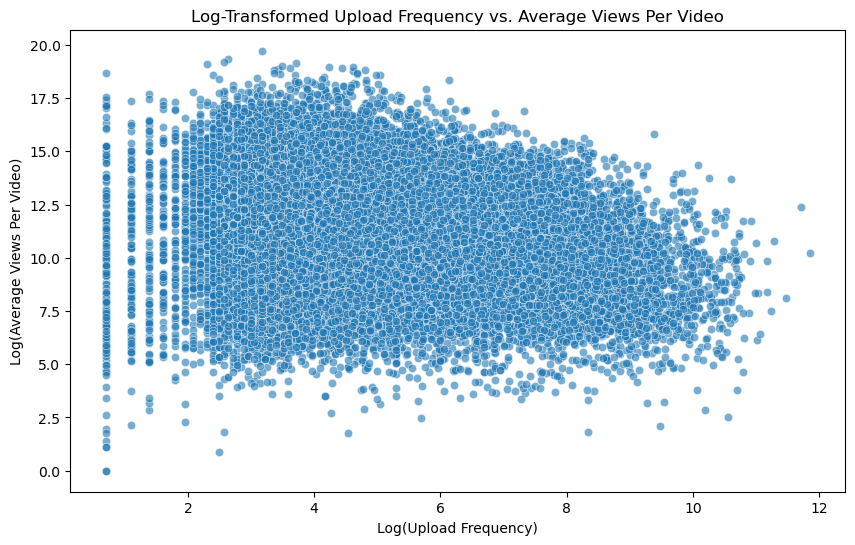

In [96]:
channel_engagement['log_upload_frequency'] = np.log1p(channel_engagement['upload_frequency'])
channel_engagement['log_view_count'] = np.log1p(channel_engagement['view_count'])

# Scatter plot with log-transformed values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_upload_frequency', y='log_view_count', data=channel_engagement, alpha=0.6)
plt.title("Log-Transformed Upload Frequency vs. Average Views Per Video")
plt.xlabel("Log(Upload Frequency)")
plt.ylabel("Log(Average Views Per Video)")
plt.show()

In [95]:
correlation = channel_engagement[['upload_frequency', 'view_count', 'like_count', 'dislike_count', 'subscribers', 'total_videos']].corr()

print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
                  upload_frequency  view_count  like_count  dislike_count  \
upload_frequency          1.000000   -0.025318   -0.035129      -0.008340   
view_count               -0.025318    1.000000    0.852779       0.219955   
like_count               -0.035129    0.852779    1.000000       0.307819   
dislike_count            -0.008340    0.219955    0.307819       1.000000   
subscribers               0.142368    0.337969    0.396779       0.105631   
total_videos              0.603128   -0.014793   -0.020799      -0.004865   

                  subscribers  total_videos  
upload_frequency     0.142368      0.603128  
view_count           0.337969     -0.014793  
like_count           0.396779     -0.020799  
dislike_count        0.105631     -0.004865  
subscribers          1.000000      0.085898  
total_videos         0.085898      1.000000  


In [97]:
category_engagement = channel_video_data.groupby('channel_category').agg({
    'upload_date': 'count',        # Total uploads
    'view_count': 'mean',          # Average views
    'like_count': 'mean',          # Average likes
    'dislike_count': 'mean'        # Average dislikes
}).reset_index()

# Rename columns for clarity
category_engagement.rename(columns={'upload_date': 'upload_frequency'}, inplace=True)


In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='upload_frequency', y='view_count', data=category_engagement, ci=None)
plt.title("Upload Frequency vs. Average Views Per Video (By Category)")
plt.xlabel("Upload Frequency")
plt.ylabel("Average Views Per Video")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Long-Tail Analysis

Assess whether the majority of uploads come from a few dominant channels or if the distribution is more equal.

### Consistency Analysis

Consistency measures the regularity of video uploads within a channel category over a specific time period. It reflects how evenly spaced or predictable the uploads are across time, providing insight into the stability of content creation behavior.

High consistency indicates uploads occur at regular intervals. Low consistency indicates irregular or sporadic uploads.

Channels that upload consistently are often more professional, as they follow a predictable schedule. High consistency often correlates with better audience retention and channel growth.

## Step 3: Timeseries Analysis

## Step 4: Comparing the three Analysis

Add any comparative metrics or additional aggregations as needed.

## Step 5: Some ML Algorithms